In [1]:
## 자산 및 전략에 대해 기본적인 평가를 수행할 수 있습니다.

In [1]:
# 기본 패키지
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
## fred = Fred(api_key='Your API Key')

fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf
from quant_functions import anal_funcs
import baseloader
import portfolio_obtimizer

In [3]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## DataLoad

In [4]:
dataloader = baseloader.BaseLoader()

In [5]:
dataloader.save_df()

[*********************100%***********************]  4 of 4 completed


0.9179750993851477
0.8698779253276526
0.8865045988566937
1.0151852657259048
0.6633274110493379
0.7083113489442356
0.9953424146502147


[*********************100%***********************]  11 of 11 completed


0.9924568108008626
0.9936316061164165
1.044154964194505
3.0314004092937146
1.989944365166564
2.981015048507007
-0.3042008655415492
0.43391385724910864
0.1716357298024248
0.8734434533894251
1.0225564073278606


In [6]:
df_imp = pd.read_csv('trend_data.csv', index_col=0)
df_imp.index = pd.to_datetime(df_imp.index)

## Function

In [7]:
class TacticalAssetAllocation:
    def __init__(self, data, cash_asset='Cash', sma_period=200, transaction_cost=0.001):
        """
        GTAA 전략 구현 클래스
        data: 시계열 데이터 (Date, 종가 포함)
        cash_asset: 매도 시 현금 보유 자산
        sma_period: 이동평균 기간
        transaction_cost: 거래 비용 (예: 0.1% = 0.001)
        """
        self.data = data.copy()
        self.sma_period = sma_period
        self.cash_asset = cash_asset
        self.initial_capital = 1000000000
        self.transaction_cost = transaction_cost  # 거래 비용 (예: 0.1%)
        
    def calculate_sma(self):
        """ 각 자산의 이동평균 계산 """
        sma_df = self.data.copy()
        for col in sma_df.columns:
            sma_df[f'{col}_SMA'] = sma_df[col].rolling(window=self.sma_period, min_periods=self.sma_period).mean()
        return sma_df
    
    def generate_signals(self):
        """ 매매 신호 생성 (가격 > 이동평균: 매수(1), 그렇지 않으면 현금(0)) """
        sma_df = self.calculate_sma()
        signal_df = pd.DataFrame(index=sma_df.index)
        for col in self.data.columns:
            signal_df[col] = (sma_df[col] > sma_df[f'{col}_SMA']).astype(int)
        return signal_df
    
    def backtest(self):
        """ 백테스트 실행 (거래 비용 포함) """
        cash_asset = self.cash_asset
        initial_capital = self.initial_capital
        transaction_cost = self.transaction_cost
        
        portfolio = self.generate_signals().shift(1).fillna(0)
        
        # 각 월별 투자 자산 수 계산
        num_assets = portfolio.drop(columns=[cash_asset]).sum(axis=1).replace(0, np.nan)
        
        # 매수 신호가 있는 자산에 동일 가중 할당
        weights = portfolio.drop(columns=[cash_asset]).div(num_assets, axis=0).fillna(0)
        
        # 현금 비중 계산 (투자되지 않은 비중을 현금으로 유지)
        weights[cash_asset] = 1 - weights.sum(axis=1)

        # 자산별 수익률 계산
        returns = self.data.pct_change().fillna(0)

        # 🔹 **(거래 비용 적용) 이전 기간 대비 포트폴리오 가중치 변화량 계산**
        weight_changes = weights.diff().fillna(0).abs()  # 가중치 변화량(절댓값)
        
        # 🔹 **거래 비용 계산**
        transaction_costs = (weight_changes * transaction_cost).sum(axis=1)

        # 🔹 **거래 비용 반영한 최종 포트폴리오 수익률**
        portfolio_returns = (weights * returns).sum(axis=1) - transaction_costs

        # 초기 투자 금액 기준으로 포트폴리오 가치 계산
        portfolio_value = (1 + portfolio_returns).cumprod() * initial_capital

        portfolio = pd.DataFrame({
            'Value': portfolio_value.values
        }, index=portfolio_value.index)

        # 기준 100으로 정규화
        portfolio = portfolio / portfolio.iloc[0] * 100

        return portfolio


In [8]:
def report_assets(data, assets):
    gm.trend_plot(data, assets, colors=[mycolors['color_norm'], mycolors['color_sub']])
    gm.asset_histogram_plot(data.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_sub']])
    gm.drawdown_plot(data, assets,  colors=[mycolors['color_norm'], mycolors['color_sub']])
    ttr_df = mf.get_ttr_df(data, assets)
    gm.ttr_plot(ttr_df, assets, colors=[mycolors['color_norm'], mycolors['color_sub']])
    rr_df = mf.get_rr_df(data, assets)
    gm.rr_trend_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_sub']])
    gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_sub']])
    return ttr_df, rr_df

## TQ

In [19]:
dataset = df_imp.copy()[:]
dataset = dataset[['TQQQ', 'SGOV']]
## dataset['SGOV'] = 100

In [41]:
# 전략 실행 및 백테스트
taa = TacticalAssetAllocation(dataset, 'SGOV', 200, 0.001)

In [42]:
strategy = taa.backtest()
signal = taa.generate_signals()
sma = taa.calculate_sma()

In [43]:
tqqq_res = dataset.copy()
tqqq_res['Strategy'] = strategy['Value']
## 판단 이후 시점부터
tqqq_res = tqqq_res[200:]
tqqq_res = tqqq_res/tqqq_res.iloc[0] * 100

In [44]:
taa.calculate_sma()

,TQQQ,SGOV,TQQQ_SMA,SGOV_SMA
Date,,,,
1975-01-02,1.000000e+02,100.000000,NaN,NaN
1975-01-03,1.027429e+02,100.027999,NaN,NaN
1975-01-06,1.054302e+02,100.055437,NaN,NaN
1975-01-07,1.062295e+02,100.082639,NaN,NaN
1975-01-08,1.041597e+02,100.109077,NaN,NaN
...,...,...,...,...
2025-03-19,9.980607e+08,907.895992,1.194470e+09,891.673272
2025-03-20,9.877978e+08,907.895992,1.194387e+09,891.842674
2025-03-21,9.970985e+08,908.166860,1.194314e+09,892.012559


In [39]:
anal_funcs.get_Vol_report(tqqq_res, method='a', unit='daily', rf=0)

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
TQQQ,36.19,18.85,11.76,0.00,1.00,1.92,3.08,36.19,-0.00,NaN
SGOV,4.42,0.30,0.00,18.86,-0.52,14.76,6211.44,-8.50,23.27,-1.68
Strategy,43.09,13.28,5.50,11.95,1.10,3.24,7.84,39.07,3.18,0.58


In [30]:
assets = ['TQQQ', 'Strategy']

In [31]:
tqqq_res

,TQQQ,SGOV,Strategy
Date,,,
1975-10-16,1.000000e+02,100.000000,1.000000e+02
1975-10-17,9.767083e+01,100.024225,9.767083e+01
1975-10-20,9.964228e+01,100.048131,9.769417e+01
1975-10-21,1.008380e+02,100.072083,9.886654e+01
1975-10-22,1.027714e+02,100.095067,1.007621e+02
...,...,...,...
2025-03-19,4.532778e+08,865.757439,8.905339e+08
2025-03-20,4.486168e+08,865.757439,8.905339e+08
2025-03-21,4.528408e+08,866.015735,8.907996e+08


In [16]:
## gm.trend_plot(tqqq_res, assets)

In [17]:
## ttr_df, rr_df= report_assets(tqqq_res, assets)

## Dotcom

In [68]:
tqqq_res_2000 = tqqq_res['2000':].copy()
tqqq_res_2000 = tqqq_res_2000/tqqq_res_2000.iloc[0] * 100

In [69]:
# ttr_df, rr_df = report_assets(tqqq_res_2000, assets)

## Financial Crisis

In [70]:
tqqq_res_2008 = tqqq_res['2004':'2013'].copy()
tqqq_res_2008 = tqqq_res_2008/tqqq_res_2008.iloc[0] * 100

In [75]:
# ttr_df, rr_df = report_assets(tqqq_res_2008, assets)

## Now

In [76]:
tqqq_res_2020 = tqqq_res['2015':].copy()
tqqq_res_2020 = tqqq_res_2020/tqqq_res_2020.iloc[0] * 100

In [21]:
# ttr_df, rr_df = report_assets(tqqq_res_2020, assets)

## Vs LAA

In [27]:
allocator = portfolio_obtimizer.PortfolioAllocator()

cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [28]:
laa_df = df_imp[["TQQQ", "TLT", "IAU"]].copy()

In [29]:
simul = pd.DataFrame()
for TQ_ratio in range(0, 101, 10):
    ratio = [TQ_ratio, (100-TQ_ratio)/2, (100-TQ_ratio)/2]
    ratio = [r*0.01 for r in ratio]
    temp = allocator.cal_rebalancing(laa_df[laa_df.columns], ratio=ratio, rebalancing='m', unit='daily')
    simul[f'TQQQ_{TQ_ratio}'] = temp['strategy']
simul['Strategy'] = strategy['Value']
simul['QQQ'] = df_imp['QQQ']

In [30]:
simul = simul[200:]
simul = simul/simul.iloc[0] * 100

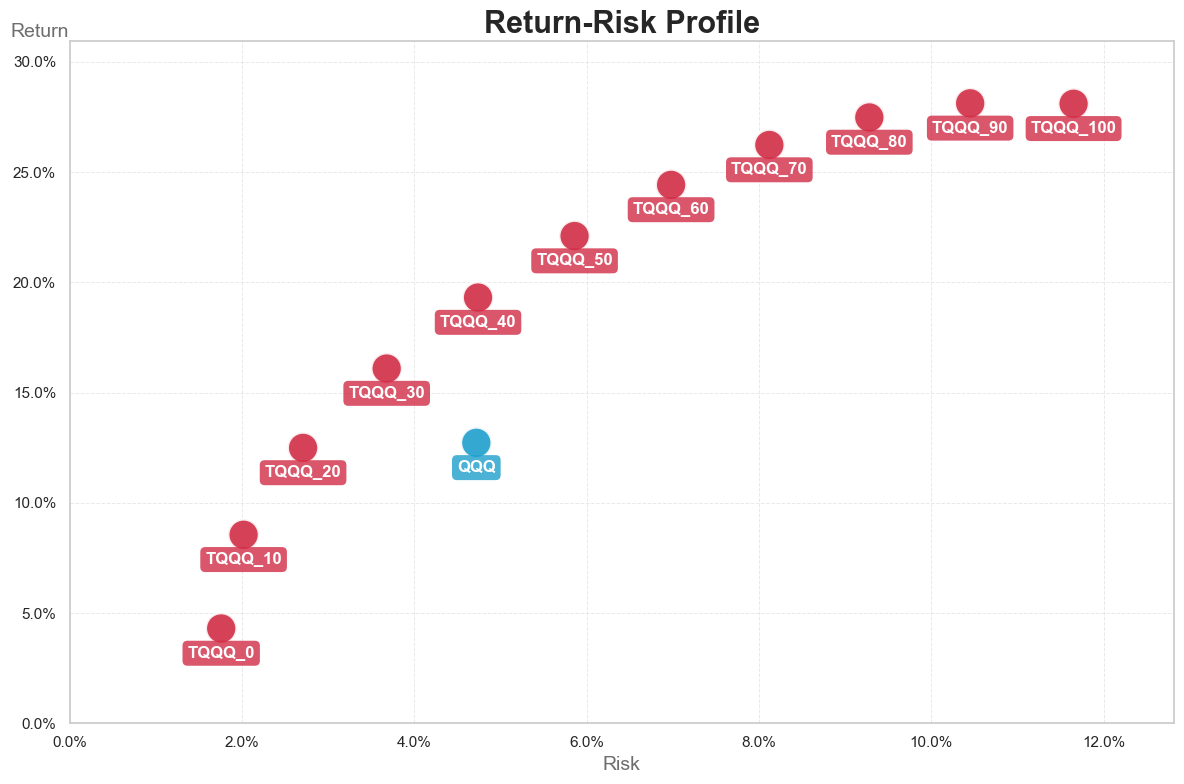

In [31]:
return_risk_df = anal_funcs.get_Vol_report(simul.drop(columns=['Strategy']), method='a', rf=0, unit='daily')
gm.return_risk_profile_plot(return_risk_df, simul.drop(columns=['Strategy']).columns, colors=[mycolors['color_norm'] for i in range(11)]+[mycolors['color_cont']])

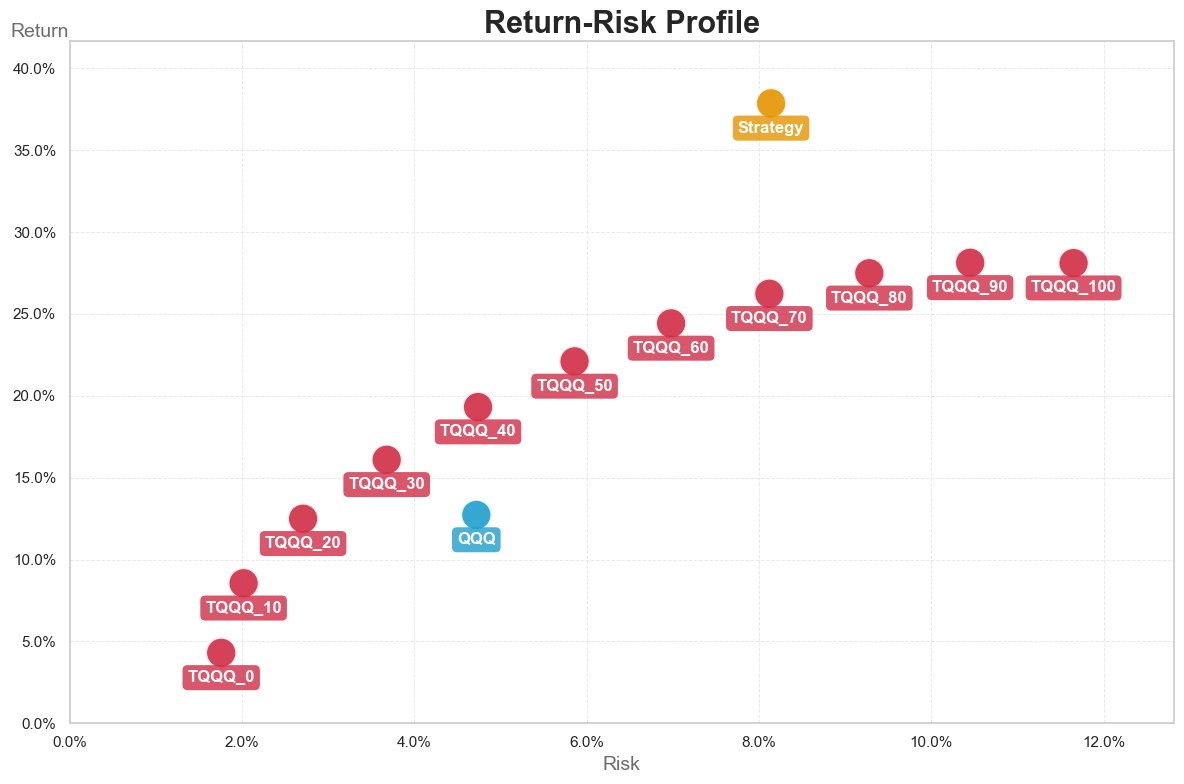

In [32]:
return_risk_df = anal_funcs.get_Vol_report(simul, method='a', rf=0, unit='daily')
gm.return_risk_profile_plot(return_risk_df, simul.columns, colors=[mycolors['color_norm'] for i in range(11)]+[mycolors['color_sub'], mycolors['color_cont']])

In [34]:
## ratio 임의 조정시
ratio = [0.7, 0.15, 0.15]
laa_strategy = allocator.cal_rebalancing(laa_df[laa_df.columns], ratio=ratio, rebalancing='m', unit='daily')
laa_strategy = laa_strategy/laa_strategy.iloc[0]*100

In [35]:
tqqq_res['LAA'] = laa_strategy['strategy']
assets = ['LAA', 'Strategy']
tqqq_res = tqqq_res/tqqq_res.iloc[0] * 100

In [38]:
8.914808e+08/1.101958e+07

80.89970761136087

In [37]:
tqqq_res

,TQQQ,SGOV,Strategy,LAA
Date,,,,
1975-10-16,1.000000e+02,100.000000,1.000000e+02,1.000000e+02
1975-10-17,9.767050e+01,100.024229,9.767050e+01,9.845502e+01
1975-10-20,9.964223e+01,100.048139,9.769385e+01,9.995089e+01
1975-10-21,1.008382e+02,100.072096,9.886638e+01,1.007366e+02
1975-10-22,1.027718e+02,100.095084,1.007622e+02,1.022671e+02
...,...,...,...,...
2025-03-10,4.362227e+08,865.030157,8.908941e+08,1.120552e+07
2025-03-11,4.311173e+08,865.202394,8.910715e+08,1.112678e+07
2025-03-12,4.458501e+08,865.202394,8.910715e+08,1.137647e+07


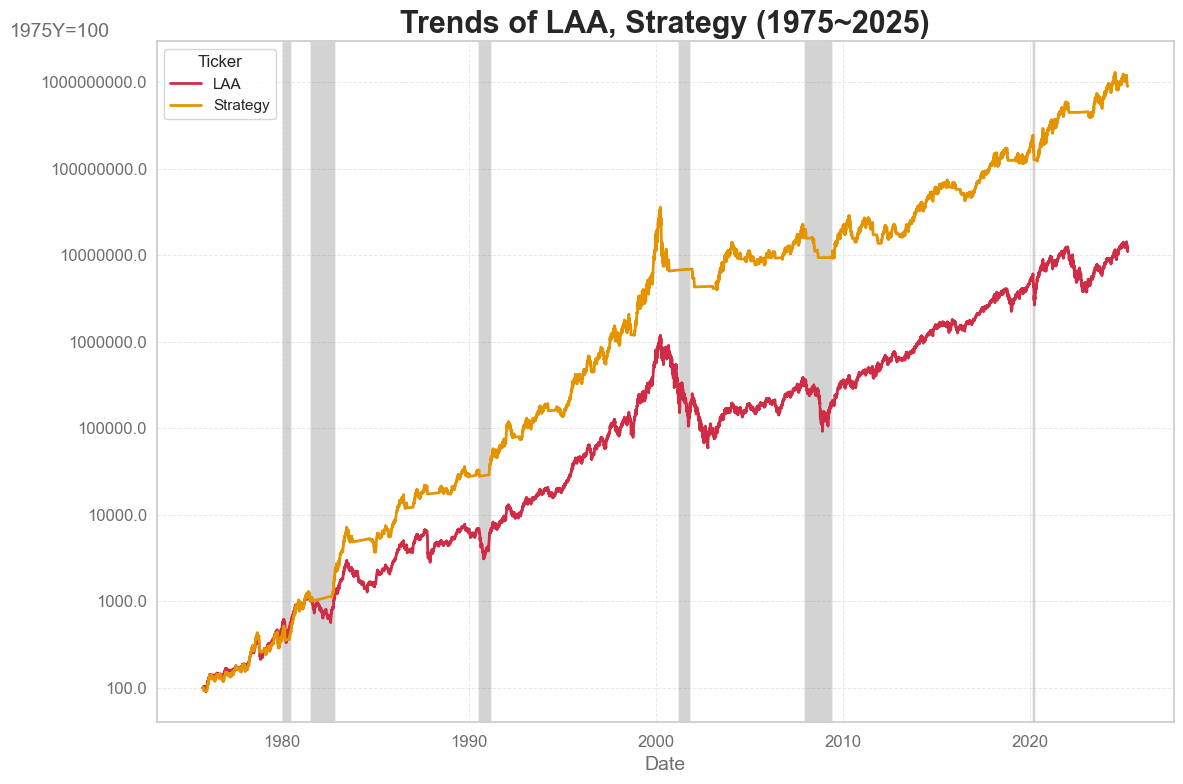

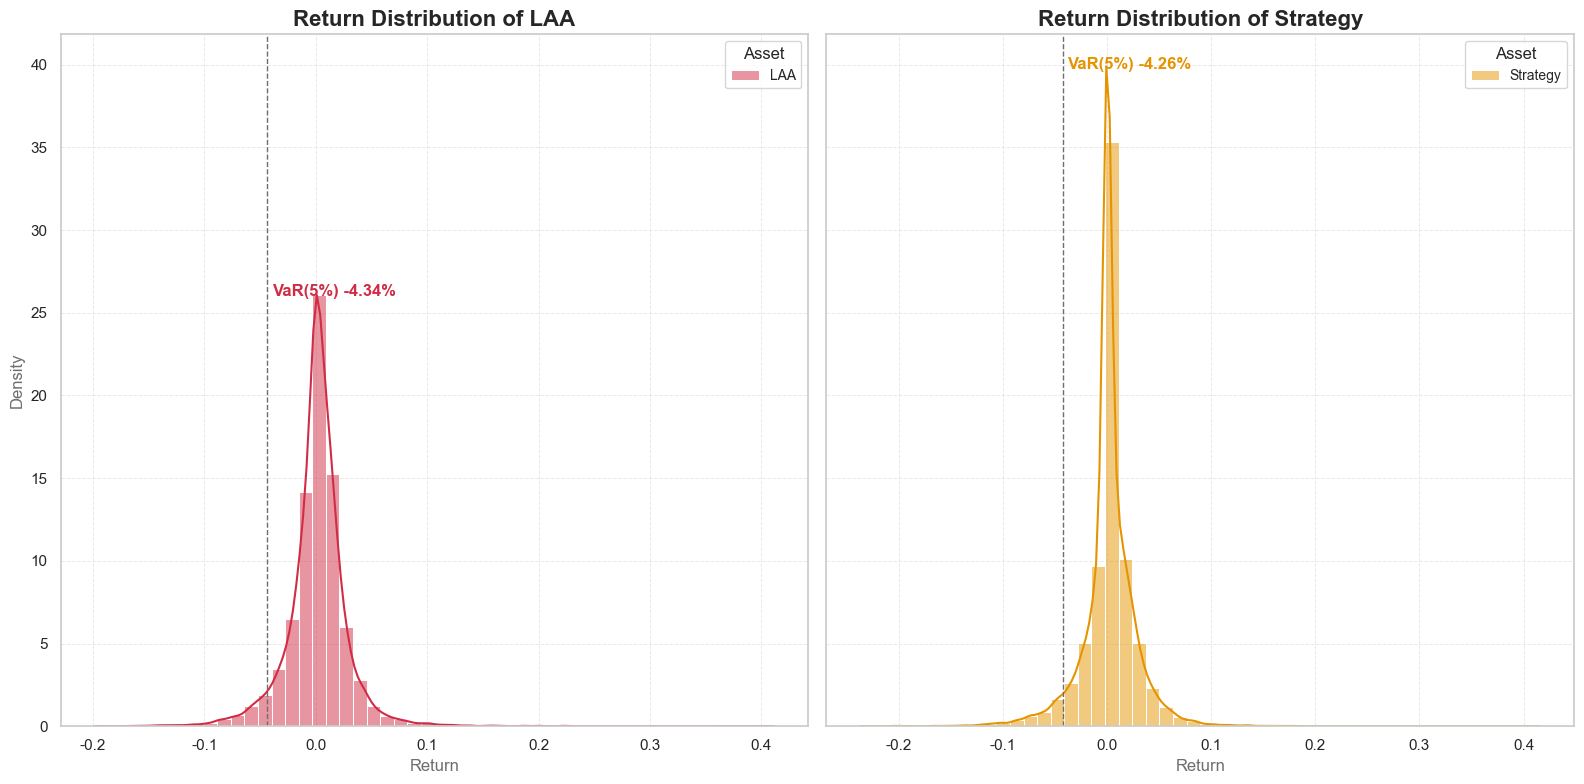

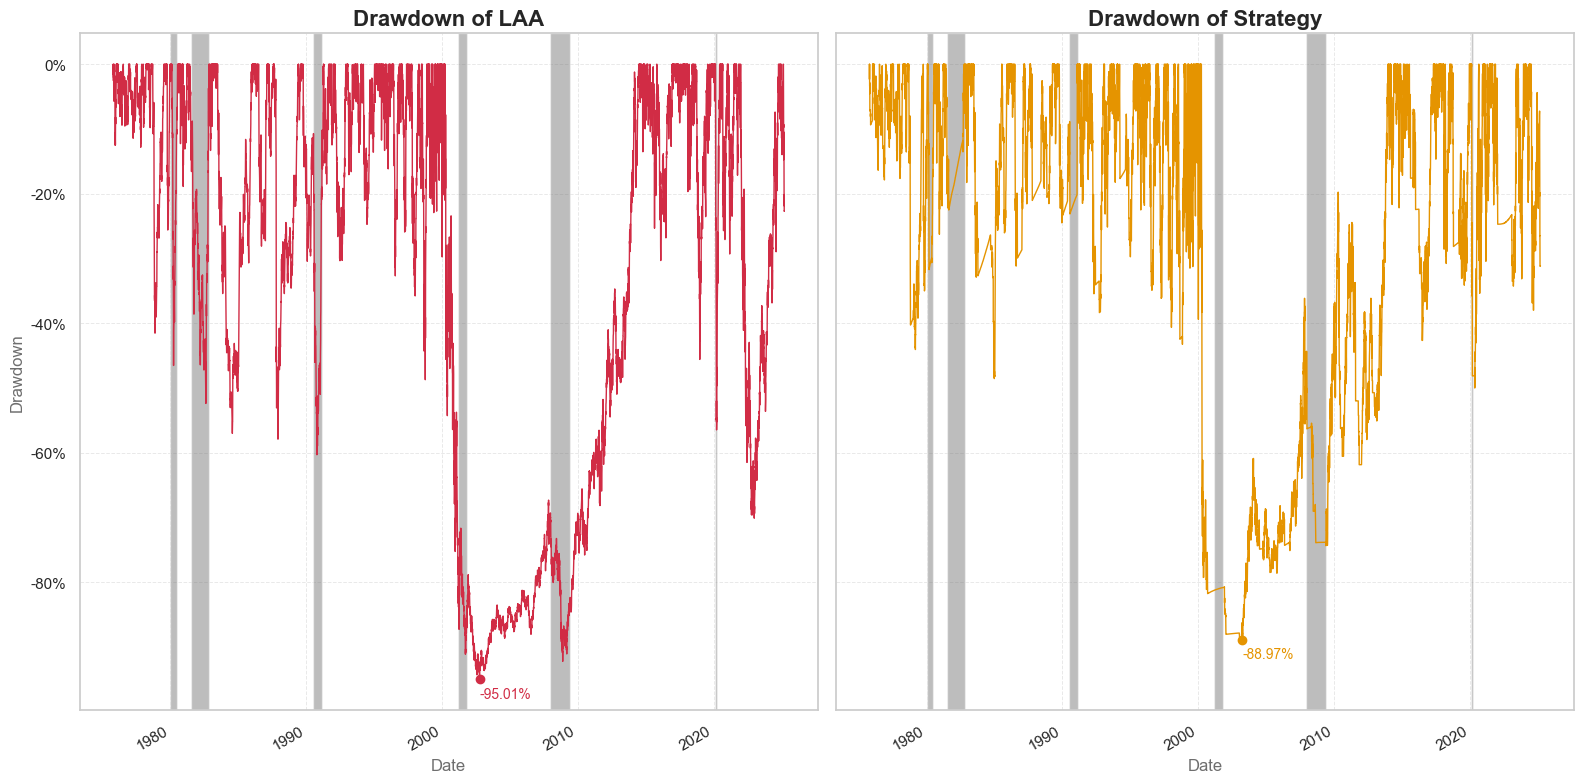

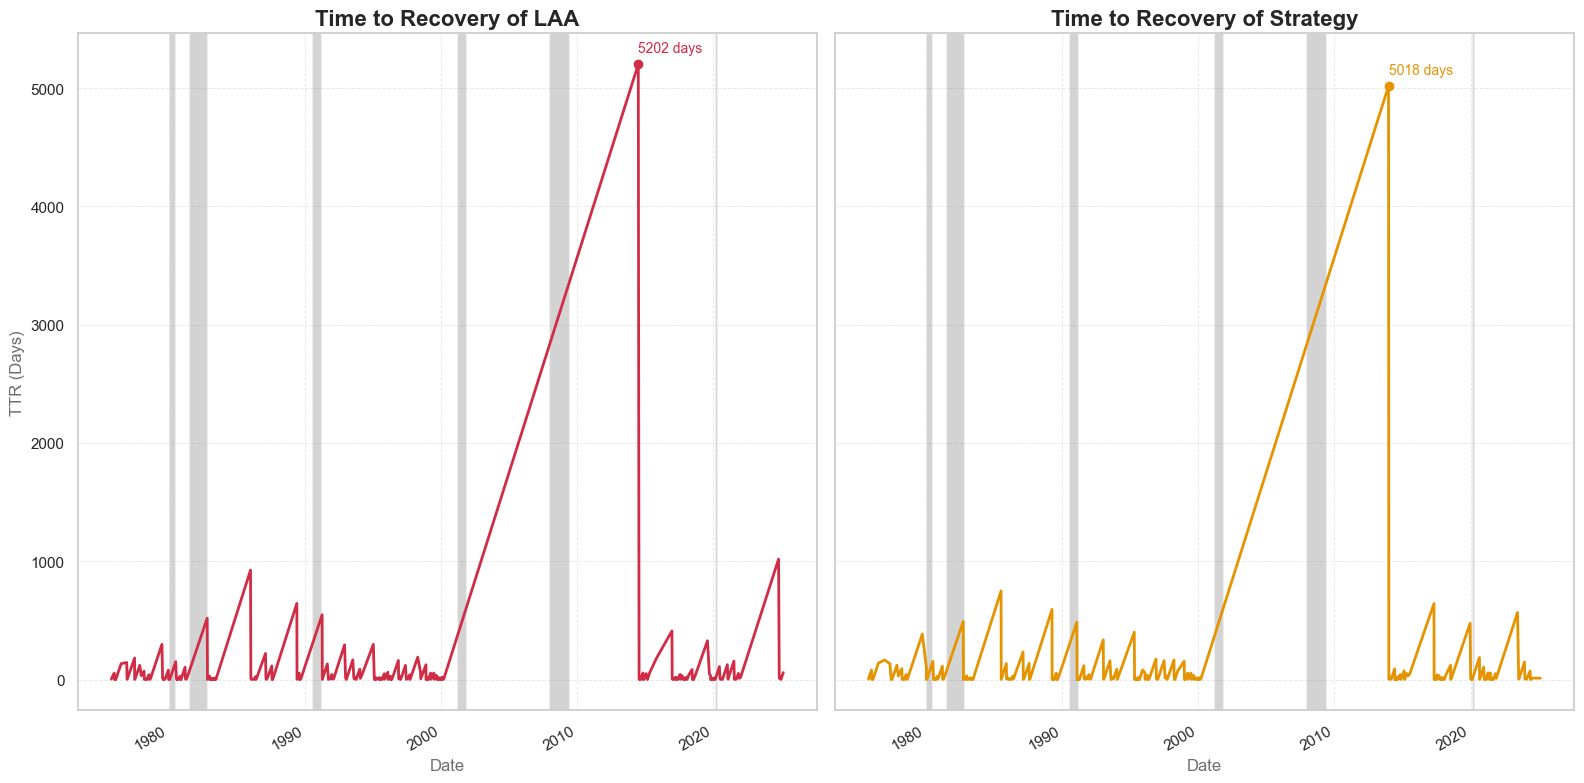

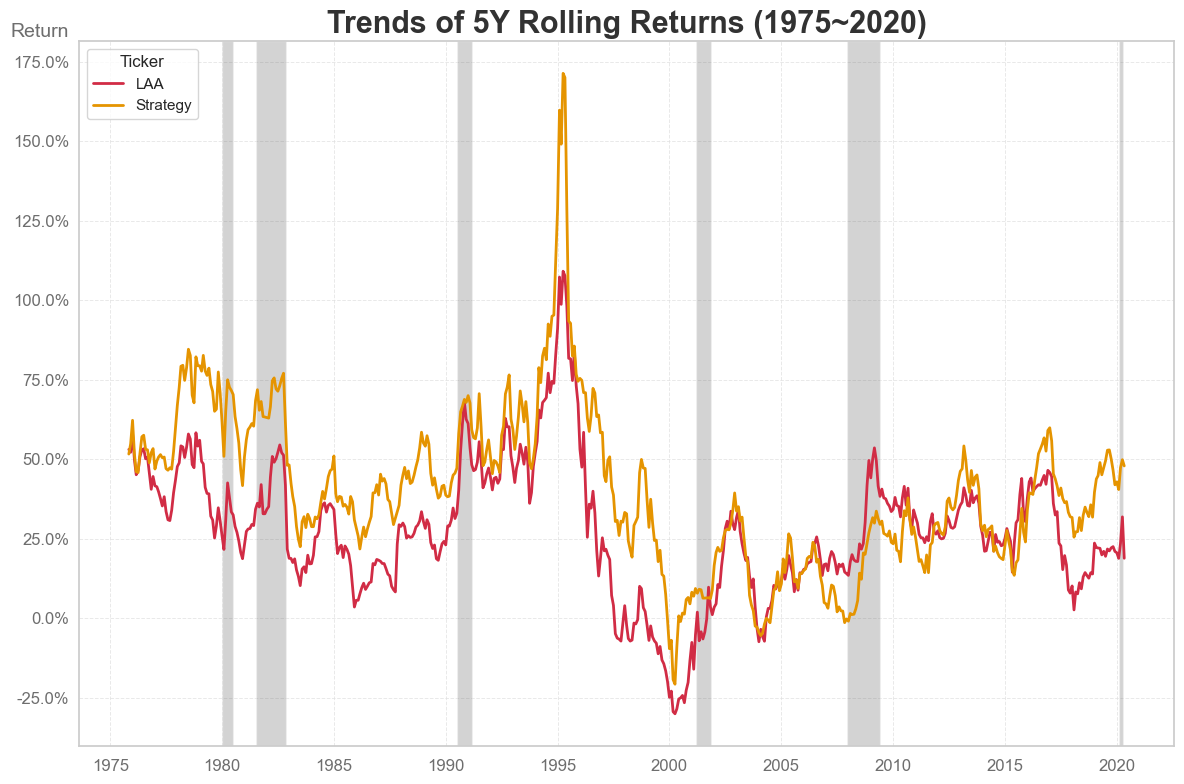

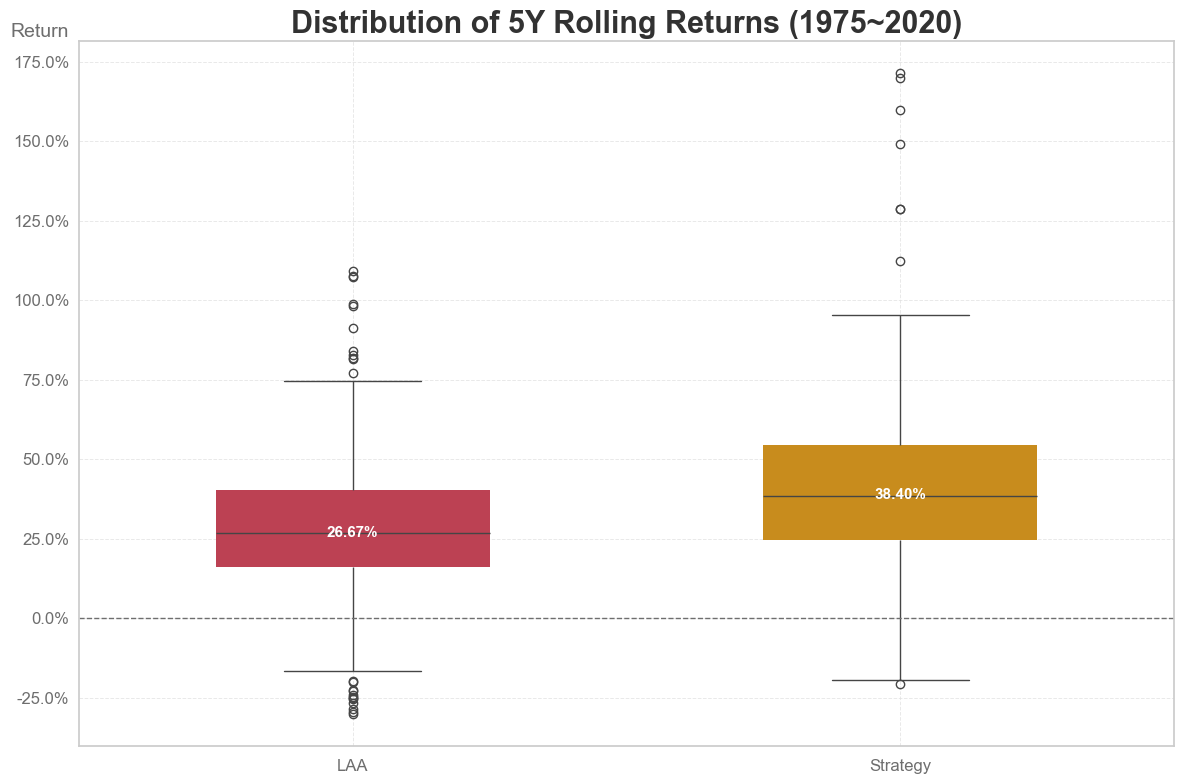

In [36]:
ttr_df, rr_df = report_assets(tqqq_res, assets)

## Vs Other safe assets

In [42]:
simul_safe = pd.DataFrame()
for a in ['SHY', 'IEF', 'TLT', 'IAU']:
    simul_safe[f"w.{a}"] = TacticalAssetAllocation(df_imp[['TQQQ', a]], a, 200).backtest()['Value']
simul_safe['Strategy'] = strategy['Value']

In [43]:
simul_safe = simul_safe[200:]
simul_safe = simul_safe/simul_safe.iloc[0] * 100

In [44]:
figsize=(12, 8)
def return_risk_profile_plot(df, assets, target_col='Return', risk_col='Volatility(Down)', colors=None, title=True, auto_lim = False):
    """
    Enhanced Return vs Downside Risk plot with improved design and annotations.
    """
    data = df[[target_col, risk_col]].copy()
    data.index = assets  # Set index as asset names

    # Calculate Sortino Ratios
    data['Sortino Ratio'] = data[target_col] / data[risk_col]

    # Use provided colors or default palette
    if colors is None:
        colors = sns.color_palette('tab10', len(assets))

    # Graph settings
    plt.figure(figsize=figsize)
    sizes = 500

    x = data[risk_col]
    y = data[target_col]
    labels = data.index

    scatter = plt.scatter(x, y, c=colors, s=sizes, edgecolors="white", linewidth=2, alpha=0.9)

    # Add labels
    for i, label in enumerate(labels):
        plt.text(
            x[i], y[i] - abs(y.max()) * 0.005, label, fontsize=12, ha="center", va="center", 
            color="white", fontweight="bold", bbox=dict(facecolor=colors[i], edgecolor='none', alpha=0.8, boxstyle="round,pad=0.3")
        )

    # Axis formatters
    def percent_formatter(x, pos):
        return f"{round(x, 1)}%"

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(percent_formatter))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(percent_formatter))

    # Axis settings
    if title:
        plt.title(f"Return-Risk Profile", fontsize=22, fontweight="bold")
    else:
        pass
    plt.xlabel("Risk", fontsize=14, color=mycolors['color_around'])
    plt.ylabel("Return", fontsize=14, labelpad=-40, color=mycolors['color_around'], loc="top", rotation=0)
    plt.grid(color=mycolors["color_around2"], linestyle="--", linewidth=0.7, alpha=0.7)
    if auto_lim == False:
        plt.xlim(7.8, 8.3)
        plt.ylim(34.5, 38.5)

    # Layout adjustments
    plt.tight_layout()
    plt.show()

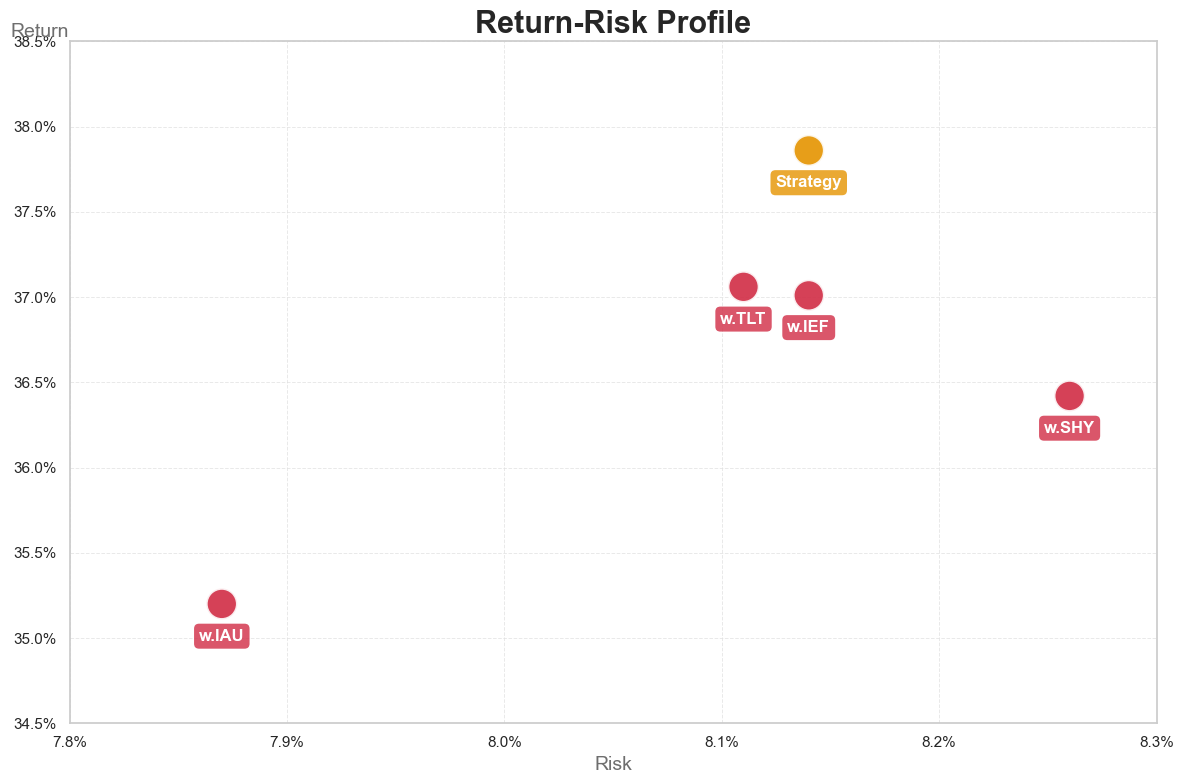

In [45]:
return_risk_df = anal_funcs.get_Vol_report(simul_safe, method='a', rf=0, unit='daily')
return_risk_profile_plot(return_risk_df, simul_safe.columns, colors=[mycolors['color_norm'] for i in range(len(simul_safe.columns)-1)]+[mycolors['color_sub']])

In [54]:
df_ori = dataloader.get_target_df()

[*********************100%***********************]  10 of 10 completed


In [55]:
signal_df = df_ori[['TQQQ']].dropna()
signal_df[f'TQQQ_SMA'] = df_ori['TQQQ'].rolling(window=200, min_periods=200).mean()
signal_df = signal_df.dropna()

In [56]:
def find_cross_points(df, price_col='Close', ma_col='MA200'):
    """
    주가와 이동평균선의 교차 지점을 찾는 함수.

    Parameters:
    - df (pd.DataFrame): 주가 데이터프레임 (price_col, ma_col 포함)
    - price_col (str): 주가 컬럼 이름 (기본값: 'Close')
    - ma_col (str): 이동평균선 컬럼 이름 (기본값: 'MA200')

    Returns:
    - pd.DataFrame: 교차 시점과 교차 유형('golden' 또는 'dead')을 포함한 데이터프레임
    """
    price = df[price_col]
    ma = df[ma_col]
    
    # 골든크로스 및 데드크로스 조건
    golden_cross = (price.shift(1) < ma.shift(1)) & (price >= ma)
    dead_cross = (price.shift(1) > ma.shift(1)) & (price <= ma)

    # 교차 지점 정보 생성
    cross_points = df[golden_cross | dead_cross].copy()
    cross_points['cross_type'] = ['golden' if gc else 'dead' for gc in golden_cross[golden_cross | dead_cross]]
    cross_points = cross_points.reset_index()[['Date', price_col, 'cross_type']]
    cross_points.rename(columns={price_col: 'Value'}, inplace=True)

    return cross_points


In [57]:
def trend_plot(df, assets, highlight_periods=None, cross_points=None, colors=None, title=True, yscale='log'):
    """
    Plots a cumulative return graph for given assets with optional highlight periods and cross points.

    Parameters:
        df (DataFrame): A DataFrame containing date-indexed asset data.
        assets (list): List of asset column names to include in the plot.
        highlight_periods (list of tuples): List of (start_date, end_date) tuples to highlight on the graph.
        cross_points (DataFrame): DataFrame with cross points containing ['Date', 'Value', 'cross_type'] columns.
        colors (list): List of colors for the lines, must match the number of assets.
    """
    data = df[assets].copy()
    _df = data.reset_index()
    _df = _df.melt(id_vars='Date', value_vars=assets, var_name='Ticker', value_name='Value')

    # Use provided colors or default palette
    if colors is None:
        colors = sns.color_palette('tab10', len(assets))

    # Plot the main line chart
    sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)

    # Title and axis labels
    if title:
        plt.title(f'Trends of {", ".join(assets)} ({data.index[0].year}~{data.index[-1].year})', fontsize=22, fontweight='bold')

    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"Price", fontsize=14, labelpad=-50, loc="top", rotation=0)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Set y-axis to logarithmic scale
    plt.gca().tick_params(axis="y", pad=1)
    if yscale == 'log':
        # Set y-axis to logarithmic scale
        plt.yscale('log')

    # Add grid
    plt.grid(linestyle="--", linewidth=0.7, alpha=0.7)

    # Highlight periods if provided
    if highlight_periods:
        for start, end in highlight_periods:
            plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), facecolor='gray', alpha=0.3)

    # Plot cross points if provided
    if cross_points is not None:
        for _, row in cross_points.iterrows():
            plt.scatter(row['Date'], row['Value'],
                        color='green' if row['cross_type'] == 'golden' else 'red',
                        label=row['cross_type'].capitalize() + ' Cross',
                        zorder=5)

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Formatting y-axis numbers
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{round(y, 1)}'))

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()


In [58]:
cross_points = find_cross_points(signal_df, price_col='TQQQ', ma_col='TQQQ_SMA')

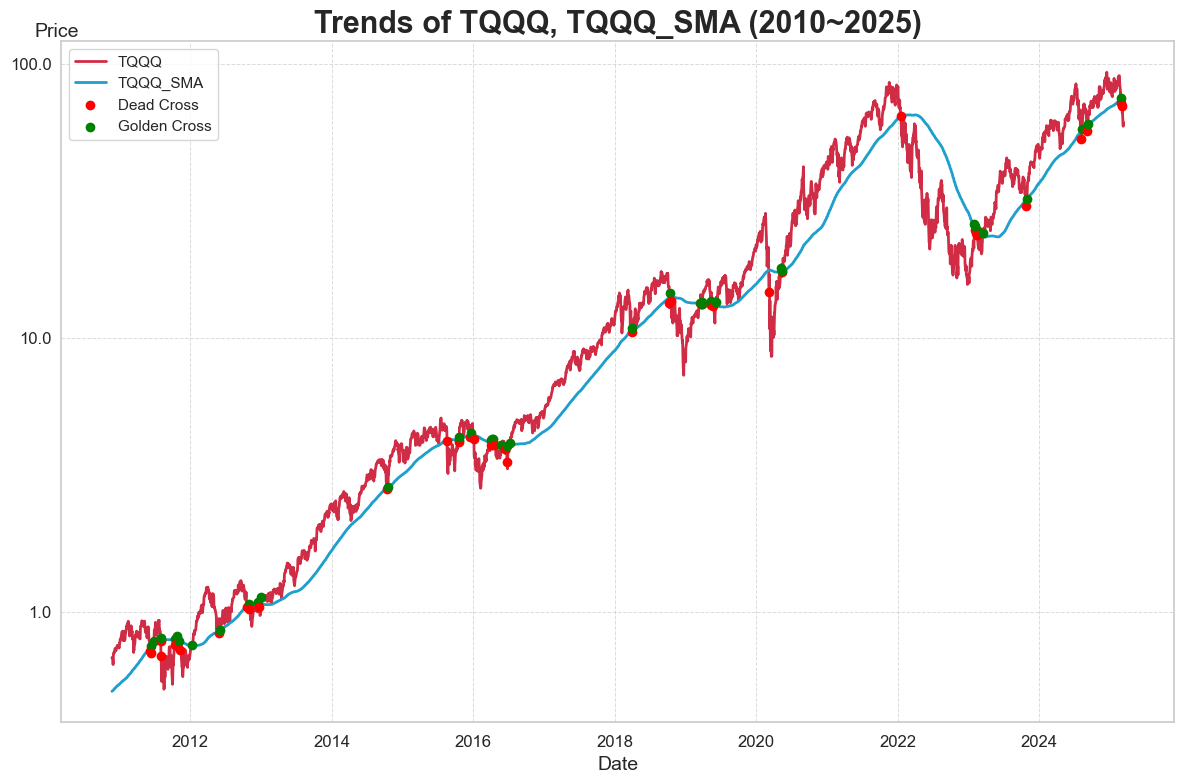

In [59]:
trend_plot(signal_df, ['TQQQ', 'TQQQ_SMA'], colors=[mycolors['color_norm'], mycolors['color_cont']], cross_points=cross_points)

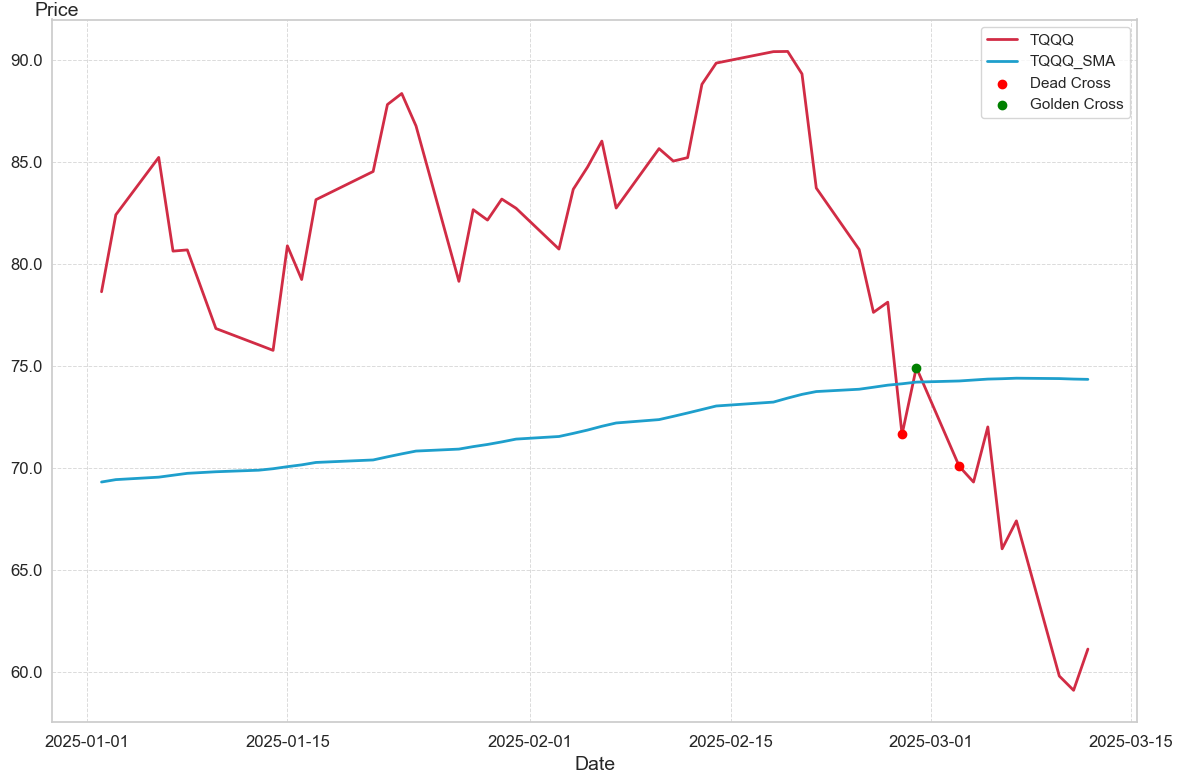

In [63]:
cross_points = find_cross_points(signal_df['2025':], price_col='TQQQ', ma_col='TQQQ_SMA')
trend_plot(signal_df['2025':], ['TQQQ', 'TQQQ_SMA'], colors=[mycolors['color_norm'], mycolors['color_cont']], cross_points=cross_points, yscale='linear', title=False)

Ticker,TQQQ,TQQQ_SMA
Date,,
2010-11-24,0.684790,0.515733
2010-11-26,0.680480,0.517054
2010-11-29,0.671008,0.518320
2010-11-30,0.645498,0.519377
2010-12-01,0.686544,0.520602
...,...,...
2025-03-06,66.040001,74.370728
2025-03-07,67.410004,74.396318
2025-03-10,59.810001,74.377475


## GTAA

In [7]:
## 프로젝트마다 필요한 데이터
tickers = ['SPY', 'EFA', 'IEF', 'GSG', 'VNQ']
gtaa_ori = yf.download(tickers, ignore_tz = True, auto_adjust=True)
gtaa_ori = gtaa_ori['Close'].dropna()

[*********************100%***********************]  5 of 5 completed


In [9]:
dataset = df_imp.copy()
dataset = dataset[['TQQQ', 'SGOV']]

# 전략 실행 및 백테스트
taa = TacticalAssetAllocation(dataset, 'SGOV', 200)

# # 전략 실행 및 백테스트
# gtaa_ori['SGOV'] = df_imp['SGOV']
# gtaaset = gtaa_ori.copy()
# taa = TacticalAssetAllocation(gtaaset, 'SGOV', 200)

In [10]:
portfolio = taa.backtest()

In [12]:
taa.calculate_sma()[['TQQQ', 'TQQQ_SMA']].tail(10)

,TQQQ,TQQQ_SMA
Date,,
2025-02-26,1.254881e+09,1.193576e+09
2025-02-27,1.150789e+09,1.194616e+09
2025-02-28,1.203477e+09,1.195888e+09
2025-03-03,1.125730e+09,1.196683e+09
2025-03-04,1.113361e+09,1.197194e+09
2025-03-05,1.156733e+09,1.197952e+09
2025-03-06,1.060834e+09,1.198242e+09
2025-03-07,1.082841e+09,1.198538e+09
2025-03-10,9.607580e+08,1.198198e+09
